In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
        
    closeDataSet = closeDataSet.loc[weightDf.iloc[0].name:] # 데이터셋 일자를 weightDf에 맞춘다.
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

## FAA

투자전략 

https://www.youtube.com/watch?v=1Wq1vUYbUkY

---

1. 투자 대상: VTI(미국 전체 주식), VEA(미국 제외 선진국 주식), VWO(전 세계 신흥국 주식), BND(미국 전체 채권), SHY(미국 단기국채), DBC(원자재), VNQ(미국 리츠)


2. 7개 자산의 모멘텀, 변동성, 상관성을 가중평균 평균하여 상위 3개 종목에 투자

* 단, 모멘텀 < 1 인 종목의 비중은 현금에 투자
* 모멘텀 : 4개월 수익률 순위 (높을수록 좋음)
* 변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)
* 상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)
* 가중평균 : (모멘텀 * 1) + (변동성 * 0.5) + (상관성 * 0.5) 값이 낮은 순서대로 순위를 매김

In [2]:
closeDataSet = pd.read_csv("./동적자산배분데이터.csv", index_col=0, parse_dates=True)
closeDataSet = closeDataSet.loc[:"2022-06"]

In [3]:
# 데이터 준비
faaCol = ['VTI', 'VEA', 'VWO', 'SHY', 'BND', 'DBC', 'VNQ']
faaData = closeDataSet[faaCol]
faaData

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-01-02,36.17632,19.22968,18.37935,74.71815,54.50851,21.93,21.13848
2009-01-05,36.16846,18.94444,18.67543,74.86900,54.27989,22.16,20.74913
2009-01-06,36.46711,19.11141,19.00852,74.90449,53.93349,22.74,21.78539
2009-01-07,35.44540,18.88182,18.00184,74.85125,54.09976,21.58,21.05462
2009-01-08,35.60259,19.10445,17.89081,74.86900,54.00970,21.66,20.89888
...,...,...,...,...,...,...,...
2022-06-24,195.19000,41.58000,42.19000,82.64000,74.83000,27.70,93.12000
2022-06-27,194.59000,41.50000,42.22000,82.55000,74.47000,27.64,92.98000
2022-06-28,190.58000,41.28000,41.94000,82.53000,74.51000,27.97,91.85000
2022-06-29,190.26000,41.03000,41.83000,82.63000,74.94000,27.49,91.28000


In [4]:
# 리밸런싱 날짜
faaRebalDate = getRebalancingDate(faaData)
faaRebalDate

DatetimeIndex(['2009-01-30', '2009-02-27', '2009-03-31', '2009-04-30',
               '2009-05-29', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-30',
               ...
               '2021-09-30', '2021-10-29', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30'],
              dtype='datetime64[ns]', length=162, freq=None)

**7개 자산의 모멘텀, 변동성, 상관성을 가중평균 평균하여 상위 3개 종목에 투자**  
**단, 모멘텀 < 0인 종목의 비중은 현금에 투자**

In [5]:
# 리밸런싱 일자 가격 데이터
faaDataOnRebalDate = faaData.loc[faaRebalDate]
faaDataOnRebalDate

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-01-30,32.33312,16.43289,15.89225,74.78914,53.57325,20.25,18.00574
2009-02-27,28.93005,14.77708,15.51474,74.68072,53.25962,19.11,14.30995
2009-03-31,31.32320,16.02202,17.43928,75.05394,53.84230,20.00,14.83104
2009-04-30,34.76575,17.91598,20.48153,74.93019,54.09305,19.98,19.38175
2009-05-29,36.66508,20.25557,24.14556,74.97200,54.45713,23.23,19.88874
...,...,...,...,...,...,...,...
2022-02-28,221.17000,47.79000,47.82000,84.56000,81.92000,23.87,102.54000
2022-03-31,227.67000,48.03000,46.13000,83.35000,79.54000,26.06,108.37000
2022-04-29,206.88000,44.77000,43.44000,82.90000,76.19000,27.53,103.94000
2022-05-31,206.36000,45.51000,43.64000,83.35000,76.68000,28.80,99.07000


**모멘텀 순위 구하기**  

In [6]:
# 4개월 모멘텀
momentum4 = faaDataOnRebalDate / faaDataOnRebalDate.shift(4)
momentum4.dropna(inplace=True)
momentum4

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,1.133979,1.232624,1.519329,1.002445,1.016499,1.147160,1.104578
2009-06-30,1.272025,1.345769,1.518130,1.002951,1.028814,1.183673,1.345420
2009-07-31,1.265740,1.372447,1.497878,0.999063,1.031009,1.152000,1.437969
2009-08-31,1.182727,1.282549,1.266354,1.004805,1.036599,1.106607,1.257946
2009-09-30,1.167814,1.179099,1.181177,1.006612,1.040017,0.949634,1.306699
...,...,...,...,...,...,...,...
2022-02-28,0.933561,0.916922,0.943940,0.984974,0.959475,1.118033,0.940389
2022-03-31,0.975241,0.966398,0.937792,0.971558,0.931164,1.337782,1.015271
2022-04-29,0.856859,0.876812,0.878285,0.969137,0.898997,1.324832,0.895957
2022-05-31,0.909836,0.927073,0.878599,0.981165,0.923855,1.284567,0.932511


**모멘텀이 높은 순으로 순위를 구해야한다.**
- pandas의 rank 함수를 사용

In [7]:
df = pd.DataFrame({'A': [4, 8, 1, 8, 6], 'B': [5, 2, 11, 7, 3], 'C': [6, 10, 5, 1, 1]})
df

,A,B,C
0,4,5,6
1,8,2,10
2,1,11,5
3,8,7,1
4,6,3,1


In [8]:
# 기본값으론 열방향 (axis=0) 을 따라서 값이 낮은 순서로 순위를 부여하고. 동점자는 평균값을 부여한다.
# 값이 높은 순서로 순위를 부여하려면? ascending=False
# 동점 처리는 어떻게 할까? method="first" 먼저 관측되는 순위를 높게
# 행방향으로 바꾸려면?, axis=1 

df.rank(ascending=False, method="first", axis=1 )

,A,B,C
0,3.0,2.0,1.0
1,2.0,3.0,1.0
2,3.0,1.0,2.0
3,1.0,2.0,3.0
4,1.0,2.0,3.0


In [9]:
# 모멘텀 순위
momentum4Score = momentum4.rank(method="first", axis=1, ascending=False)
momentum4Score

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,4.0,2.0,1.0,7.0,6.0,3.0,5.0
2009-06-30,4.0,2.0,1.0,7.0,6.0,5.0,3.0
2009-07-31,4.0,3.0,1.0,7.0,6.0,5.0,2.0
2009-08-31,4.0,1.0,2.0,7.0,6.0,5.0,3.0
2009-09-30,4.0,3.0,2.0,6.0,5.0,7.0,1.0
...,...,...,...,...,...,...,...
2022-02-28,6.0,7.0,4.0,2.0,3.0,1.0,5.0
2022-03-31,3.0,5.0,6.0,4.0,7.0,1.0,2.0
2022-04-29,7.0,6.0,5.0,2.0,3.0,1.0,4.0
2022-05-31,6.0,4.0,7.0,2.0,5.0,1.0,3.0


**변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)**

* 표준편차는 어떻게 구할까?
    * pandas의 std()함수를 사용하면 아주 쉽게 구할 수 있다.

In [10]:
df

,A,B,C
0,4,5,6
1,8,2,10
2,1,11,5
3,8,7,1
4,6,3,1


In [11]:
df.std()

A    2.966479
B    3.577709
C    3.781534
dtype: float64

* 그럼 해야 할 일은 일일수익률을 4개월 단위로 뽑아낸 뒤, std() 함수를 사용하면 끝.

In [12]:
faaRebalDate

DatetimeIndex(['2009-01-30', '2009-02-27', '2009-03-31', '2009-04-30',
               '2009-05-29', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-30',
               ...
               '2021-09-30', '2021-10-29', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30'],
              dtype='datetime64[ns]', length=162, freq=None)

In [13]:
# 4개월 단위로 뽑아내기 위해 리밸런싱 일자 데이터 내림차순 정렬
reverseFaaRebalDate = faaRebalDate[::-1] 
reverseFaaRebalDate

DatetimeIndex(['2022-06-30', '2022-05-31', '2022-04-29', '2022-03-31',
               '2022-02-28', '2022-01-31', '2021-12-31', '2021-11-30',
               '2021-10-29', '2021-09-30',
               ...
               '2009-10-30', '2009-09-30', '2009-08-31', '2009-07-31',
               '2009-06-30', '2009-05-29', '2009-04-30', '2009-03-31',
               '2009-02-27', '2009-01-30'],
              dtype='datetime64[ns]', length=162, freq=None)

In [14]:
std4 = pd.DataFrame() # 빈 데이터 프레임
dayReturn = getDayReturn(closeDataSet=faaData) # 일간 수익률

for index, date in enumerate(reverseFaaRebalDate) :
    # 4개월 데이터를 잡을 수 없으면 break
    if index >= len(reverseFaaRebalDate) - 4:
        break
        
    # 4개월 전 날짜
    before4month = reverseFaaRebalDate[index+4]
    
    # 4개월 일일수익률 표준편차
    std = dayReturn.loc[date:before4month:-1].std()
    std.name = date
    std4 = std4.append(std)
    
std4 = std4.sort_index(ascending=True)
std4

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,0.023042,0.025117,0.031062,0.001139,0.003739,0.019325,0.057762
2009-06-30,0.020967,0.023259,0.028572,0.001323,0.003766,0.018802,0.052868
2009-07-31,0.015564,0.018516,0.023302,0.001270,0.003408,0.016585,0.042139
2009-08-31,0.013388,0.016732,0.020824,0.001252,0.003449,0.016099,0.030887
2009-09-30,0.011447,0.014445,0.017418,0.001237,0.003248,0.015546,0.025654
...,...,...,...,...,...,...,...
2022-02-28,0.011663,0.009697,0.010918,0.001036,0.003230,0.011882,0.011691
2022-03-31,0.013661,0.012402,0.015116,0.001173,0.003803,0.017572,0.012485
2022-04-29,0.014587,0.012629,0.015575,0.001340,0.004275,0.017958,0.013304
2022-05-31,0.016726,0.014292,0.016728,0.001458,0.004690,0.019362,0.014943


In [15]:
std4Score = std4.rank(method="first", axis=1, ascending=True)
std4Score

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,4.0,5.0,6.0,1.0,2.0,3.0,7.0
2009-06-30,4.0,5.0,6.0,1.0,2.0,3.0,7.0
2009-07-31,3.0,5.0,6.0,1.0,2.0,4.0,7.0
2009-08-31,3.0,5.0,6.0,1.0,2.0,4.0,7.0
2009-09-30,3.0,4.0,6.0,1.0,2.0,5.0,7.0
...,...,...,...,...,...,...,...
2022-02-28,5.0,3.0,4.0,1.0,2.0,7.0,6.0
2022-03-31,5.0,3.0,6.0,1.0,2.0,7.0,4.0
2022-04-29,5.0,3.0,6.0,1.0,2.0,7.0,4.0
2022-05-31,5.0,3.0,6.0,1.0,2.0,7.0,4.0


**상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)**

* 상관성은 어떻게 구하나요?
    * pandas의 corr() 함수를 사용하면 피어슨 상관계수를 쉽게 계산 가능
    
피어슨 상관계수?
https://hyen4110.tistory.com/38

In [16]:
df

,A,B,C
0,4,5,6
1,8,2,10
2,1,11,5
3,8,7,1
4,6,3,1


In [17]:
df.corr(method="pearson")

,A,B,C
A,1.000000,-0.711378,-0.026743
B,-0.711378,1.000000,-0.255003
C,-0.026743,-0.255003,1.000000


In [18]:
corr4 = pd.DataFrame()
dayReturn = getDayReturn(closeDataSet=faaData) # 일간 수익률

for index, date in enumerate(reverseFaaRebalDate):
    # 4개월 데이터를 잡을 수 없으면 break
    if index >= len(reverseFaaRebalDate) - 4:
        break
        
    # 4개월 전 날짜
    before4month = reverseFaaRebalDate[index+4]
    
    # 4개월 상관성
    corr = (dayReturn.loc[date:before4month:-1].corr(method="pearson")).sum(axis=1)-1 # 자신에 대한 상관계수를 제거하기 위해 -1
    corr.name = date
    corr4 = corr4.append(corr)
    
corr4 = corr4.sort_index(ascending=True)
corr4

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,2.930272,2.998565,2.840376,-0.692050,0.139162,2.006465,2.611201
2009-06-30,3.082819,3.219992,3.041236,-0.201621,0.282010,2.213572,2.650935
2009-07-31,2.908690,3.140253,2.910901,-0.322777,-0.135217,2.454379,2.454610
2009-08-31,2.882286,3.086290,2.824256,-0.239042,-0.023411,2.311037,2.334111
2009-09-30,2.645654,2.838076,2.544765,-0.577723,-0.441162,2.275537,2.012756
...,...,...,...,...,...,...,...
2022-02-28,2.467873,2.419820,1.807749,0.723342,0.349386,0.895364,2.496118
2022-03-31,2.089302,1.796414,1.750931,0.848561,0.870592,-0.492058,2.125781
2022-04-29,2.151582,1.786992,1.729311,0.937389,1.280959,-0.517284,1.951320
2022-05-31,2.387960,2.139964,1.927409,0.776565,1.197969,0.031034,2.194959


In [19]:
corr4Score = corr4.rank(method="first", axis=1, ascending=True)
corr4Score

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,6.0,7.0,5.0,1.0,2.0,3.0,4.0
2009-06-30,6.0,7.0,5.0,1.0,2.0,3.0,4.0
2009-07-31,5.0,7.0,6.0,1.0,2.0,3.0,4.0
2009-08-31,6.0,7.0,5.0,1.0,2.0,3.0,4.0
2009-09-30,6.0,7.0,5.0,1.0,2.0,4.0,3.0
...,...,...,...,...,...,...,...
2022-02-28,6.0,5.0,4.0,2.0,1.0,3.0,7.0
2022-03-31,6.0,5.0,4.0,2.0,3.0,1.0,7.0
2022-04-29,7.0,5.0,4.0,2.0,3.0,1.0,6.0
2022-05-31,7.0,5.0,4.0,2.0,3.0,1.0,6.0


**가중평균 : (모멘텀 * 1) + (변동성 * 0.5) + (상관성 * 0.5) 값이 낮은 순서대로 순위를 매김**

In [20]:
# 가중평균
weightedAverage = (momentum4Score + 0.5 * (std4Score + corr4Score))
weightedAverage.dropna(inplace=True)
weightedAverage

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,9.0,8.0,6.5,8.0,8.0,6.0,10.5
2009-06-30,9.0,8.0,6.5,8.0,8.0,8.0,8.5
2009-07-31,8.0,9.0,7.0,8.0,8.0,8.5,7.5
2009-08-31,8.5,7.0,7.5,8.0,8.0,8.5,8.5
2009-09-30,8.5,8.5,7.5,7.0,7.0,11.5,6.0
...,...,...,...,...,...,...,...
2022-02-28,11.5,11.0,8.0,3.5,4.5,6.0,11.5
2022-03-31,8.5,9.0,11.0,5.5,9.5,5.0,7.5
2022-04-29,13.0,10.0,10.0,3.5,5.5,5.0,9.0
2022-05-31,12.0,8.0,12.0,3.5,7.5,5.0,8.0


In [21]:
totalScore = weightedAverage.rank(method="first", axis=1, ascending=True)
totalScore

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,6.0,3.0,2.0,4.0,5.0,1.0,7.0
2009-06-30,7.0,2.0,1.0,3.0,4.0,5.0,6.0
2009-07-31,3.0,7.0,1.0,4.0,5.0,6.0,2.0
2009-08-31,5.0,1.0,2.0,3.0,4.0,6.0,7.0
2009-09-30,5.0,6.0,4.0,2.0,3.0,7.0,1.0
...,...,...,...,...,...,...,...
2022-02-28,6.0,5.0,4.0,1.0,2.0,3.0,7.0
2022-03-31,4.0,5.0,7.0,2.0,6.0,1.0,3.0
2022-04-29,7.0,5.0,6.0,1.0,3.0,2.0,4.0
2022-05-31,6.0,4.0,7.0,1.0,3.0,2.0,5.0


In [22]:
# 모멘텀 1 미만에 대해서는 현금투자,
# 랭킹에서 상위 3가지 뽑아 내는 방법

weight = (totalScore <= 3) & (momentum4 >= 1) # 가중평균 3위 내, 모멘텀 1이상
weight

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,False,True,True,False,False,True,False
2009-06-30,False,True,True,True,False,False,False
2009-07-31,True,False,True,False,False,False,True
2009-08-31,False,True,True,True,False,False,False
2009-09-30,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...
2022-02-28,False,False,False,False,False,True,False
2022-03-31,False,False,False,False,False,True,True
2022-04-29,False,False,False,False,False,True,False
2022-05-31,False,False,False,False,False,True,False


In [23]:
faaWeight = weight.replace(True, 1/3).replace(False, 0)
faaWeight

,VTI,VEA,VWO,SHY,BND,DBC,VNQ
2009-05-29,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000
2009-06-30,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000
2009-07-31,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333
2009-08-31,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000
2009-09-30,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.333333
...,...,...,...,...,...,...,...
2022-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
2022-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333
2022-04-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
2022-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000


In [24]:
faaWeight['cash'] = 1 - faaWeight.sum(axis=1)
faaWeight = faaWeight.loc['2010-12-31':]
faaWeight

,VTI,VEA,VWO,SHY,BND,DBC,VNQ,cash
2010-12-31,0.333333,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.333333
2011-01-31,0.333333,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.333333
2011-02-28,0.333333,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.333333
2011-03-31,0.333333,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.333333
2011-04-29,0.000000,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.000000
...,...,...,...,...,...,...,...,...
2022-02-28,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.666667
2022-03-31,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.333333
2022-04-29,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.666667
2022-05-31,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.666667


In [25]:
# 현금 컬럼 추가
faaDataWithCash = faaData.copy()
faaDataWithCash.loc[:, 'cash'] = 1
faaDataWithCash

,VTI,VEA,VWO,SHY,BND,DBC,VNQ,cash
2009-01-02,36.17632,19.22968,18.37935,74.71815,54.50851,21.93,21.13848,1
2009-01-05,36.16846,18.94444,18.67543,74.86900,54.27989,22.16,20.74913,1
2009-01-06,36.46711,19.11141,19.00852,74.90449,53.93349,22.74,21.78539,1
2009-01-07,35.44540,18.88182,18.00184,74.85125,54.09976,21.58,21.05462,1
2009-01-08,35.60259,19.10445,17.89081,74.86900,54.00970,21.66,20.89888,1
...,...,...,...,...,...,...,...,...
2022-06-24,195.19000,41.58000,42.19000,82.64000,74.83000,27.70,93.12000,1
2022-06-27,194.59000,41.50000,42.22000,82.55000,74.47000,27.64,92.98000,1
2022-06-28,190.58000,41.28000,41.94000,82.53000,74.51000,27.97,91.85000,1
2022-06-29,190.26000,41.03000,41.83000,82.63000,74.94000,27.49,91.28000,1


In [26]:
faaDayReturn, faaCumReturn = getRebalancingPortfolioResult(closeDataSet=faaDataWithCash, weightDf=faaWeight)
faaCagr, faaDD, faaMDD = getEvaluation(faaCumReturn)

최종 수익률: 1.8451672797423768
cagr: 1.0547888189492414
mdd: 10.671472270752396


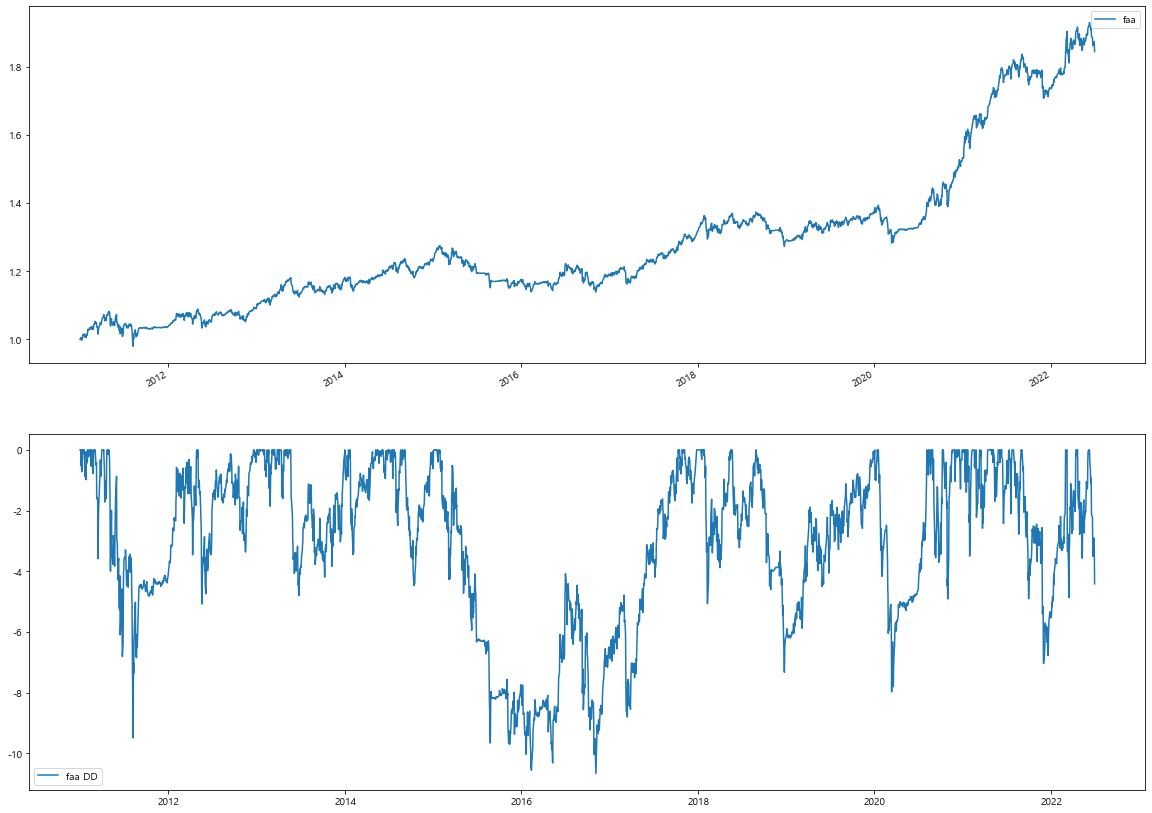

In [27]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
faaCumReturn.plot(label="faa")
# stockCumReturn.plot(label="시장")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-faaDD, label="faa DD")
# plt.plot(-stockDD, label="시장 DD")
plt.legend()

plt.show()

#### FAA 비중 함수

In [28]:
def getFAAWeight(closeDataSet):
    faaCol = ['VTI', 'VEA', 'VWO', 'SHY', 'BND', 'DBC', 'VNQ']
    faaData = closeDataSet[faaCol]
    
    # 리밸런싱 날짜
    faaRebalDate = getRebalancingDate(faaData)

    # 모멘텀 : 4개월 수익률
    faaDataOnRebalDate = faaData.loc[faaRebalDate] # 리밸런싱 일자의 가격 데이터
    momentum4 = faaDataOnRebalDate / faaDataOnRebalDate.shift(4)
    momentum4.dropna(inplace=True)
    momentum4Score = momentum4.rank(method="max", axis=1, ascending=False)
    
    # 변동성 : 4개월 일일수익률의 표준편차(standard deviation) 순위 (낮을수록 좋음)
    std4 = pd.DataFrame()
    # 상관성 : 4개월 하나의 자산과 다른 6개 자산간의 일일수익률의 상관성(correlation)의 합 순위 (낮을수록 좋음)
    corr4 = pd.DataFrame()
    reverseFaaRebalDate = faaRebalDate[::-1]

    for index, date in enumerate(reverseFaaRebalDate) :
        if index >= len(reverseFaaRebalDate) - 4:
            break
            
        # 4개월 전 시점
        before4month = reverseFaaRebalDate[index+4]
        
        # 일일 수익률
        dayReturn = getDayReturn(closeDataSet=faaData)

        # 4개월 일일수익률 표준편차
        std = dayReturn.loc[date:before4month:-1].std()
        std.name = date
        std4 = std4.append(std)
        
        # 4개월 일일수익률 상관성
        corr = (dayReturn.loc[date:before4month:-1].corr(method="pearson")).sum(axis=1)-1
        corr.name = date
        corr4 = corr4.append(corr)
    
    # 변동성 순위 정하고, 인덱스 오름차순으로 정렬
    std4Score = std4.rank(method="first", axis=1, ascending=True)
    std4Score = std4Score.sort_index(ascending=True)
    
    # 상관성 순위 정하고, 인덱스 오름차순으로 정렬
    corr4Score = corr4.rank(method="first", axis=1, ascending=True)
    corr4Score= corr4Score.sort_index(ascending=True)
       
    # 가중평균
    totalScore = (momentum4Score + 0.5 * (std4Score + corr4Score)).rank(method="first", axis=1, ascending=True)

    # 모멘텀 1 미만에 대해서는 현금투자,
    # 랭킹에서 상위 3가지 뽑아 내는 방법
    weight = (totalScore <= 3) & (momentum4 >= 1)
    faaWeight = weight.replace(True, 1/3).replace(False, 0)
    faaWeight['cash'] = 1 - faaWeight.sum(axis=1)
    return faaWeight

In [29]:
getFAAWeight(closeDataSet)

,VTI,VEA,VWO,SHY,BND,DBC,VNQ,cash
2009-05-29,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000
2009-06-30,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000
2009-07-31,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000
2009-08-31,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000
2009-09-30,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000
...,...,...,...,...,...,...,...,...
2022-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667
2022-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333
2022-04-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667
2022-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667
